Set-up

In [1]:
# Import numpy and matplotlib 
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(19653)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

*Part 1: Detecting Change in Foot Displacement through bump (along the y axis)*

Number of Spikes for x=0.5sin(10pi*t): 75


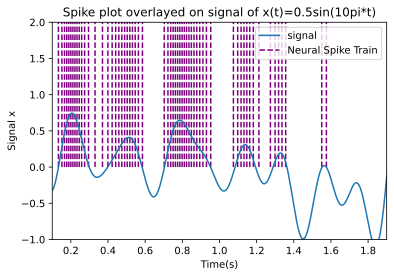

In [9]:
def scaled(xt,rms):
    rmsOg=np.sqrt(np.mean(np.square(xt[np.where(xt>0)].real)))
    xt=xt*(rms/rmsOg)
    return xt


def plotTimeAndFreq(signals, limit):
    plt.figure()
    plt.plot(signals[2],signals[3])
    plt.axis([-(limit*3)*2*np.pi, (limit*3)*2*np.pi,-5,300])
    plt.title("Frequency Domain")
    plt.xlabel("Frequency w in rad/s") #𝜔 symbol doesn't show on plot, so w used instead
    plt.ylabel("Power spectrum |X|")
    
  
    plt.figure()
    plt.plot(signals[0],signals[1])
    plt.axis([0.01, 0.99,-2,3])
    plt.title("Time Domain")
    plt.xlabel("Time t (s)")
    plt.ylabel("Signal x")

    
    
def generate_signal(T, dt, rms, limit, seed=None):
    np.random.seed(seed)
    tstep=2*np.pi/T  # 1/T but in radians
    w=np.arange(tstep, np.pi/dt, tstep) #np.pi/dt is simplification of tstep*(T/dt)/2 (div by 2 since we will reflect values)
    realCoefs=np.abs(np.random.normal(size=len(w))) #added in abs to ensure frequency domain signal doesn't have -ve values
    imCoefs=np.multiply(complex(0,1),np.random.normal(size=len(w)))
    b=limit*2*np.pi
    
    for i in range(len(w)):
        if (np.abs(w[i])>b):
            realCoefs[i]=0
            imCoefs[i]=0
            
        
        

    #Xs=np.array([], dtype = complex)
    #XsLeft=np.array([], dtype = complex)

    XsLeft=np.append(realCoefs[::-1]-imCoefs[::-1], [0]) #makes left side of array as reflection of right
    Xs=np.append(XsLeft,realCoefs+imCoefs)
    xt=np.fft.ifft(np.fft.ifftshift(Xs)).real
    
    xt=scaled(xt, rms)
    Xs=np.fft.fftshift(np.fft.fft(xt))
    
    sLeft=np.append(-1*w[::-1], [0])
    s=np.append(sLeft, w)
    t=np.arange(0, len(s))*dt
    
    #print(Xs)    #contains complex value types, so the warning of casting complex values is likely coming from plot command
    
    return t, xt, s, Xs
    
    


def spawnLif(e=1):
    tRef=0.002
    tRC=0.02
    aMax=150
    AatXInt=40
    
    
    jBias=1/(1-np.exp(((1/AatXInt)-tRef)/(-1*tRC)))
    alpha=((1/(1-np.exp(((1/aMax)-tRef)/(-1*tRC))))-1)-jBias
    return jBias, alpha
    
def generateVoltage(signal, signalString, graph=True, e=1):
    Vth=1
    Vrest=0
    Vpeak=5
    tRef=0.002
    tRC=0.02
    tstep=0.001
    lif=spawnLif(e)
    spikes=0;
    
    voltages=[]
    voltage=0 #initial voltage
    
    refractory=int(tRef/tstep) #double check
    refCount=refractory
    
    for i in signal:
        #if ((spikes==0) and (voltage<Vth)):  # * referenced in next question
            #voltage+=lif[0]*tstep*3
            
        if refCount<refractory:
            voltage=0
            refCount+=1
        elif voltage>Vth:
            voltage=Vpeak
            refCount=0
            spikes+=1
        elif voltage<Vth:
            J=lif[1]*e*i+lif[0]
            dV=(-1/tRC)*(voltage-J)*tstep
            voltage+=dV;
        voltages.append(voltage)
    
    print("Number of Spikes for "+signalString+": "+str(spikes))
    
    if (graph):
        plt.figure()
        plt.plot(time,voltages)
        plt.plot(time, signal, "--")
        plt.title("LIF Membrane Potential over time for signal "+signalString)
        plt.xlabel("Time (s)") 
        plt.ylabel("Membrane Potential (V)")


    return voltages


Number of Spikes for x=10sin(10pi*t): 69


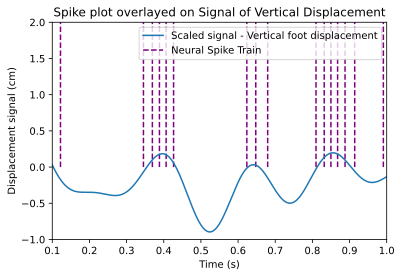

In [55]:

time=np.linspace(0,2,int(2/0.001)-1)
fullSignal=(generate_signal(2, 0.001, 0.5, 5))
signal=fullSignal[1]
ePosNeuron=generateVoltage(signal, "x=10sin(10pi*t)", False)
posSpikeLines=time[np.where(np.array(ePosNeuron)>4)]


plt.figure()
plt.plot(time, signal, label="Scaled signal - Vertical foot displacement")
plt.vlines(posSpikeLines, 0, 2, "purple", "dashed", label="Neural Spike Train")
#plt.vlines(negSpikeLines, -2,0, "purple", "dashed", label="-ve e LIF spikes")
plt.xlabel("Time (s)")
plt.ylabel("Displacement signal (cm)")
plt.title("Spike plot overlayed on Signal of Vertical Displacement")
plt.axis([0.10, 1,-1,2])
plt.legend()

_Part 2: Detecting Change in foot displacement parallel to the ground (along x or z axis)_

Helper Functions

In [2]:
def firingRate(signal, lif): #taken from """code""" above
    tRef=0.002
    tRC=0.02
    
    firingRate=np.zeros(len(signal))
    
    if (lif==None):
        lif=spawnLif()
    
    for i in range(len(firingRate)):
        J=lif[1]*lif[2]*signal[i]+lif[0]
        if(J>1):
            firingRate[i]=1/(tRef-tRC*np.log(1-(1/J)))
    return firingRate




#Helper Functions
def noisyDecoder(o_, A, x):  #from assi1
    #same d formula as before but in matrix form and with noise added in 
    decoder=np.matmul(np.matmul(np.linalg.inv(np.matmul(A, A.T)+41*o_*o_*np.identity(len(A))), A), x.T).T 
    return decoder
    
def findRmse(x, xHat):
    return np.sqrt(np.mean(np.square(x-xHat)))

def findRMS(signal):
    rms=np.sqrt(np.sum(np.square(signal))/len(signal))
    return rms

def calcFilter(t, tau):
    h=(1/tau)*(np.exp(-1*t/tau))
    h[np.where(t<0)]=0 
    return (h/np.sum(h))

def createSignal(dt, rms, lim, T):
    numOfSteps=int(T/dt)
    frequencies=np.fft.fftfreq(numOfSteps,dt)
    Xw=np.zeros(numOfSteps, dtype=np.complex)
    for i in range(numOfSteps):
        if (abs(frequencies[i])<=lim):
            real=np.random.normal()
            im=np.random.normal()
            Xw[i]=real+1j*im
    
    xtIntermediate=np.fft.ifft(Xw).real
    xt=rms*xtIntermediate/(findRMS(xtIntermediate))
    Xw=np.fft.fft(xt)
    #recommended to use this in documentation
    #for more clean iteration through 2-part arrays
    Xw=[X for freq, X in sorted(zip(frequencies, Xw))]
    
    return xt, Xw

def generateVoltage(signal, tstep, lif):
    tRef=0.002
    tRC=0.02
    
       
    voltage=0 #initial voltage
    Vpeak=5
    Vth=1
    voltages=[]
    spikeTrain=np.zeros(len(signal))
    
    refractory=int(tRef/tstep)
    refCount=refractory
    
    for i in range(len(signal)):
        #print("voltage"+str(voltage))
        #print("vth: "+str(Vth))
        #print("signal: "+str(signal[i]))
        if refCount<refractory:
            voltage=0
            refCount+=1
        elif voltage>Vth:
            voltage=Vpeak
            refCount=0
            spikeTrain[i]=1
        voltages.append(voltage)
        J=lif[1]*lif[2]*signal[i]+lif[0] #alpha*e*i+jbias
        dV=(-1/tRC)*(voltage-J)*tstep
        voltage+=dV;
        #print("withdv: "+str(signal[i]))
        
    return voltages, spikeTrain


Defining a Leaky Integrate Fire Neuron

In [3]:
#define neuron
def spawnLifUpdated():
    tRef=0.002
    tRC=0.02
    
    aMax=np.random.uniform(100,200)
    xInt=np.random.uniform(-1,1) #updated this from -2,2 
    e=np.random.choice([-1,1]) #default to e=1; can generate -1 if needed
    
    xi=xInt*e
    
    alpha=((1/(1-np.exp(((1/aMax)-tRef)/(-1*tRC))))-1)*(1/(2-xi))
    jBias=1-(alpha*xi)
    return jBias, alpha, e, aMax, xInt

Determining Neural Response to Displacement Changes in x

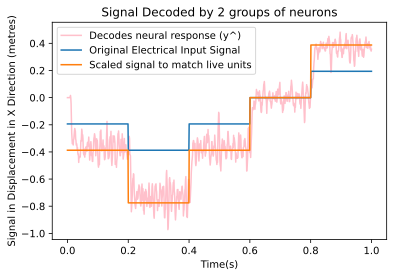

In [6]:
spikes1=[]
x=np.linspace(-1,1,int(1/0.001))
t=np.linspace(0,1, int(1/0.001))
xt=np.zeros(len(t))


timeForFilter=np.linspace(-0.5, 0.5, int(1/0.001))
h=calcFilter(timeForFilter, 0.005)
o_=20 

#new code from part a

direction=np.random.choice([-1,1])
stepSize=np.random.uniform(-.3,-.1) #smaller step size for shuffling gait
directionChange=int(np.random.uniform(2,5))
origin=0;
for i in range(directionChange): 
    origin+=stepSize*direction #add guassian noise later;
    for j in range(int(0.2*(1000))): #100*0.1 = total number of steps in 1 second times 0.1s = 100 dt
        xt[j+200*i]=origin
direction*=-1;
for i in range(directionChange, 5): 
    origin+=stepSize*direction #add guassian noise later;
    for j in range(int(0.2*(1000))): #100*0.1 = total number of steps in 1 second times 0.1s = 100 dt
        xt[j+200*i]=origin

#steps: Modifying normalization of values from cm to metres to meet neuron's tuning thresholds; number of neurons
#end of new code
#take signal, scale it, detect steps

f=2*x
a=np.zeros([1000,len(xt)])
firingRates=np.zeros([1000,len(x)])

for i in range(1000):
    currNeuron=spawnLifUpdated()
    spikes1.append(generateVoltage(xt, 0.001, currNeuron)[1])
    a[i]=np.convolve(h,spikes1[i]/0.001,mode='same')
    firingRates[i]=firingRate(x, currNeuron)
    
decoders=noisyDecoder(o_, firingRates, f)
xHatNew=np.dot(decoders,a)

spikes2=[]
y=np.linspace(-1,1,int(1/0.001))
fy=2*xt
a2=np.zeros([1000,len(xHatNew)])
firingRates2=np.zeros([1000,len(y)])
for i in range(1000):
    currNeuron=spawnLifUpdated()
    spikes2.append(generateVoltage(xHatNew, 0.001, currNeuron)[1])
    a2[i]=np.convolve(h,spikes2[i]/0.001,mode='same')
    firingRates2[i]=firingRate(y, currNeuron)
    
decoders2=noisyDecoder(o_, firingRates2,y)
yHatNew=np.dot(decoders2,a2)

#print(yHatNew)
plt.figure()
plt.plot(t,yHatNew,color="pink",label="Decodes neural response (y^)")
plt.title("Signal Decoded by 2 groups of neurons")
plt.plot(t,xt,label="Original Electrical Input Signal")
plt.plot(t,fy, label="Scaled signal to match live units")
plt.xlabel("Time(s)")
plt.ylabel("Signal in Displacement in X Direction (metres)")
plt.legend()